In [ ]:
"""
    Validate KNN
    Seems to break the 1.0 biomarkers ? 
    we are currently:
       knn for whole cohort - maybe split this into age groups as with bhs
       default n_neighbours = 5 >>> test split and validate with scoring 
"""

In [1]:
import progressbar

In [2]:
import sys
sys.path.append("../")

import pandas as pd
import numpy as np
from functions.bhs_calc_functions import getAgeGroupList, getAgeThresholds, \
                                    checkListClean, biomarkerScore, count_scores
from sklearn.impute import KNNImputer
from functions.pca_bhs import *

# %% tags=["parameters"]
upstream = ['Pull dietary variables']
product = None
biomarker_lower_quartile_scored = None
complete_cases = None
knn_impute = None
continuous_pca_biomarker = None

#%% data preparation
df = pd.read_parquet('../data/processed_data/04_ukbb_outcome_trimmed_diet.parquet')

In [3]:
# assessmentDatesDf = pd.read_csv(
#     "~/UKBB/UKB_preparation_in_progress/extraction_recoding/data/ukb47946.csv",
#     usecols=["eid","53-0.0","53-1.0"],
#     parse_dates=["53-0.0","53-1.0"])
# assessmentDatesDf.to_parquet("../data/ukb_assessment_dates.parquet", index=False)

In [4]:
# assessmentDatesDf

In [5]:
# get dates for checking if came for followup & for cox regression later 
# assessmentDatesDf = pd.read_csv(
#     "~/UKBB/UKB_preparation_in_progress/extraction_recoding/data/ukb47946.csv",
#     usecols=["eid","53-0.0","53-1.0"],
#     parse_dates=["53-0.0","53-1.0"])

assessmentDatesDf = pd.read_parquet("../data/ukb_assessment_dates.parquet")

df = pd.merge(
    df,
    assessmentDatesDf,
    how="left",
    on="eid")

df = df.rename(columns={"genetic_sex.0.0":"sex"})

markersList = ["glycated_haemoglobin","HDL_cholesterol","LDL_direct","triglycerides","systolic_bp","diastolic_bp",
 "pulse_rate","c.reactive_protein","IGF1","creatinine", "cystatin_C", "alanine_aminotransferase",
 "aspartate_aminotransferase","gamma_glutamyltransferase"]

biomarkersColumns = df.columns[
    df.columns.str.contains('|'.join([x+".0.0" for x in markersList]))|
    df.columns.str.contains('|'.join([x+".1.0" for x in markersList]))
].append(pd.Index(["eid", "age.0.0", "age.1.0", "sex"]))

prevalentDisease = df[
    (df["prevalentCancer"]==1)|
    (df["prevalentCad"]==1)|
    (df["prevalentCVD"]==1)]["eid"]

print(len(prevalentDisease))

94123


In [6]:
assessmentDatesDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502461 entries, 0 to 502460
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   eid     502461 non-null  int64         
 1   53-0.0  502460 non-null  datetime64[ns]
 2   53-1.0  20344 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 11.5 MB


In [7]:
# population selection
biomarkersDf = df[~(df["eid"].isin(prevalentDisease)) &
                  (pd.notnull(df["53-1.0"])) & 
                  (pd.notnull(df["sex"]))]
biomarkersDf = biomarkersDf[biomarkersColumns]
# biomarkersDf = biomarkersDf.dropna()
completeCasesDf = biomarkersDf.dropna()

In [8]:
biomarkersDf

,pulse_rate.0.0,pulse_rate.1.0,diastolic_bp.0.0,diastolic_bp.1.0,systolic_bp.0.0,systolic_bp.1.0,alanine_aminotransferase.0.0,alanine_aminotransferase.1.0,aspartate_aminotransferase.0.0,aspartate_aminotransferase.1.0,...,IGF1.0.0,IGF1.1.0,LDL_direct.0.0,LDL_direct.1.0,triglycerides.0.0,triglycerides.1.0,eid,age.0.0,age.1.0,sex
3,64.0,64.0,73.0,81.0,133.0,132.0,32.91,NaN,24.3,NaN,...,19.058,NaN,3.774,NaN,3.087,NaN,1000049,41.0,44.0,Male
6,78.0,84.0,117.0,99.0,191.0,179.0,NaN,14.14,NaN,21.0,...,NaN,20.923,NaN,4.011,NaN,0.795,1000070,66.0,69.0,Female
59,49.0,52.0,75.0,77.0,123.0,126.0,NaN,18.12,NaN,23.5,...,NaN,17.067,NaN,4.650,NaN,1.097,1000606,53.0,58.0,Female
60,71.0,55.0,83.0,83.0,141.0,135.0,17.81,19.58,24.3,23.0,...,29.094,19.039,4.648,5.030,3.114,2.096,1000612,59.0,62.0,Male
102,65.0,66.0,81.0,78.0,140.0,151.0,31.02,23.70,30.8,28.4,...,12.292,12.815,3.720,3.645,1.495,1.795,1001037,61.0,66.0,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502229,55.0,53.0,83.0,87.0,146.0,167.0,26.81,24.75,34.6,30.7,...,17.010,15.715,2.945,2.542,2.064,2.481,6022596,64.0,69.0,Male
502266,86.0,86.0,79.0,75.0,144.0,153.0,25.03,NaN,25.3,NaN,...,22.629,NaN,2.729,NaN,2.225,NaN,6022966,57.0,61.0,Female
502416,68.0,65.0,82.0,80.0,145.0,132.0,20.49,32.04,19.3,23.2,...,22.079,22.698,3.753,3.400,1.392,1.607,6024466,55.0,59.0,Male
502437,58.0,64.0,77.0,76.0,127.0,128.0,14.72,23.75,17.0,21.9,...,28.218,28.866,4.018,4.164,1.050,1.185,6024672,41.0,46.0,Male


In [9]:
biomarkersDf.columns

Index(['pulse_rate.0.0', 'pulse_rate.1.0', 'diastolic_bp.0.0',
       'diastolic_bp.1.0', 'systolic_bp.0.0', 'systolic_bp.1.0',
       'alanine_aminotransferase.0.0', 'alanine_aminotransferase.1.0',
       'aspartate_aminotransferase.0.0', 'aspartate_aminotransferase.1.0',
       'creatinine.0.0', 'creatinine.1.0', 'c.reactive_protein.0.0',
       'c.reactive_protein.1.0', 'cystatin_C.0.0', 'cystatin_C.1.0',
       'gamma_glutamyltransferase.0.0', 'gamma_glutamyltransferase.1.0',
       'glycated_haemoglobin.0.0', 'glycated_haemoglobin.1.0',
       'HDL_cholesterol.0.0', 'HDL_cholesterol.1.0', 'IGF1.0.0', 'IGF1.1.0',
       'LDL_direct.0.0', 'LDL_direct.1.0', 'triglycerides.0.0',
       'triglycerides.1.0', 'eid', 'age.0.0', 'age.1.0', 'sex'],
      dtype='object')

In [10]:
biomarkersDf["alanine_aminotransferase.0.0"].value_counts(dropna=False)

alanine_aminotransferase.0.0
NaN      1168
15.06      19
17.55      18
16.12      18
18.67      18
         ... 
42.67       1
59.90       1
27.18       1
34.61       1
35.79       1
Name: count, Length: 3986, dtype: int64

In [11]:
knn = KNNImputer().set_output(transform="pandas")

for ageGroup in progressbar.progressbar(getAgeGroupList(biomarkersDf, "age.0.0")):
    
     biomarkersDf.loc[ageGroup,
                          biomarkersDf.columns.str.contains('|'.join([x+".0.0" for x in markersList]))]=\
    knn.fit_transform(
        biomarkersDf.loc[ageGroup,
                          biomarkersDf.columns.str.contains('|'.join([x+".0.0" for x in markersList]))]
    )


100% (6 of 6) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07


In [12]:
biomarkersDf["alanine_aminotransferase.0.0"].value_counts(dropna=False)

alanine_aminotransferase.0.0
20.634976    73
26.425695    63
17.606898    30
28.944962    21
15.060000    19
             ..
37.920000     1
20.740000     1
41.050000     1
32.360000     1
35.790000     1
Name: count, Length: 4643, dtype: int64

In [13]:
biomarkersDf["alanine_aminotransferase.0.0"].value_counts(dropna=False).sum()

16847

In [14]:
biomarkersDf["aspartate_aminotransferase.1.0"].value_counts(dropna=False)

aspartate_aminotransferase.1.0
NaN      2079
25.1      150
24.0      150
23.1      142
25.0      134
         ... 
83.6        1
48.0        1
173.7       1
46.6        1
59.4        1
Name: count, Length: 555, dtype: int64

In [15]:
for ageGroup in progressbar.progressbar(getAgeGroupList(biomarkersDf, "age.1.0")):
    
     biomarkersDf.loc[ageGroup,
                          biomarkersDf.columns.str.contains('|'.join([x+".1.0" for x in markersList]))]=\
    knn.fit_transform(
        biomarkersDf.loc[ageGroup,
                          biomarkersDf.columns.str.contains('|'.join([x+".1.0" for x in markersList]))]
    )

   

100% (6 of 6) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05


In [16]:
"""
    Compare knn vs baseline df 
    compare bhs complete cases vs bhs knn - especially t1
"""

'\n    Compare knn vs baseline df \n    compare bhs complete cases vs bhs knn - especially t1\n'

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot melted dataframe in a single command
# to compare few biomarkers 

def compareDistributionKnn(completeCasesDf, biomarkersDf, imputedVar):
    completeCasesDf["compare_var"] = completeCasesDf[imputedVar]
    plotDf = pd.merge(
        biomarkersDf[[imputedVar, "eid"]],
        completeCasesDf[["compare_var", "eid"]],
        how="left",
        on="eid")

    sns.histplot(plotDf[[imputedVar, "compare_var"]].melt(), x='value', hue='variable',
                 multiple='dodge', shrink=.75, bins=20);

/var/tmp/pbs.8186257.pbs/ipykernel_3418500/1504957966.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completeCasesDf["compare_var"] = completeCasesDf[imputedVar]


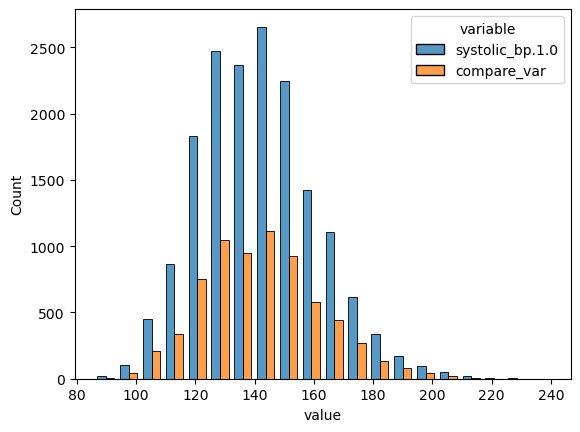

In [25]:
compareDistributionKnn(completeCasesDf, biomarkersDf, "systolic_bp.1.0")

/var/tmp/pbs.8186257.pbs/ipykernel_3418500/1504957966.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completeCasesDf["compare_var"] = completeCasesDf[imputedVar]


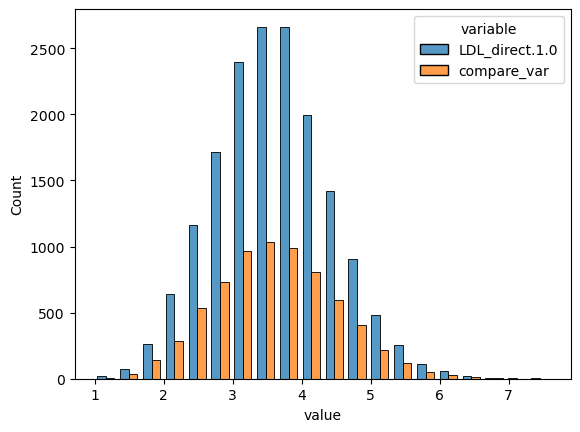

In [27]:
compareDistributionKnn(completeCasesDf, biomarkersDf, "LDL_direct.1.0")

/var/tmp/pbs.8186257.pbs/ipykernel_3418500/1504957966.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completeCasesDf["compare_var"] = completeCasesDf[imputedVar]


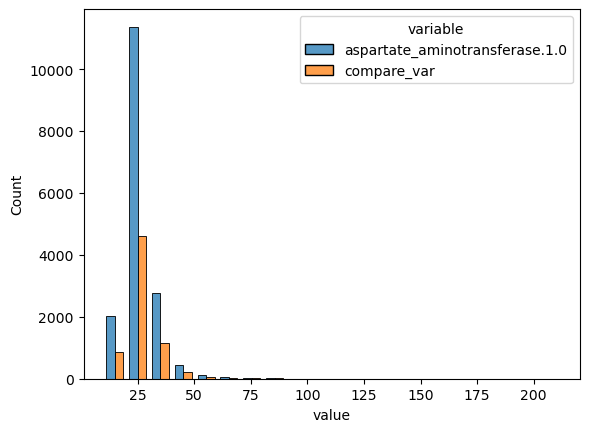

In [28]:
compareDistributionKnn(completeCasesDf, biomarkersDf, "aspartate_aminotransferase.1.0")

/var/tmp/pbs.8186257.pbs/ipykernel_3418500/1504957966.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completeCasesDf["compare_var"] = completeCasesDf[imputedVar]


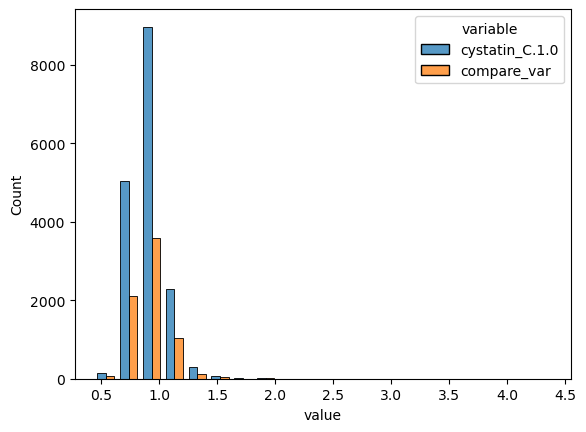

In [29]:
compareDistributionKnn(completeCasesDf, biomarkersDf, "cystatin_C.1.0")

In [40]:
t1 = pd.DataFrame(np.random.rand(4,3))
t2 = pd.DataFrame(np.random.rand(10,3))

In [41]:
t1

,0,1,2
0,0.482675,0.980602,0.180896
1,0.865516,0.497097,0.542922
2,0.055948,0.518090,0.366539
3,0.890015,0.364513,0.240264


In [43]:
t1.index = [0,2,4,6]

In [44]:
t1

,0,1,2
0,0.482675,0.980602,0.180896
2,0.865516,0.497097,0.542922
4,0.055948,0.518090,0.366539
6,0.890015,0.364513,0.240264


In [45]:
t2

,0,1,2
0,0.877457,0.246135,0.374440
1,0.144423,0.520206,0.848977
2,0.228418,0.731060,0.562411
3,0.283500,0.142373,0.629935
4,0.778121,0.215342,0.303582
5,0.579588,0.493004,0.657574
6,0.296170,0.923312,0.087927
7,0.899904,0.394160,0.899079
8,0.641630,0.483941,0.663990
9,0.040367,0.952393,0.647587


In [46]:
t1[0] = t2[0]

In [47]:
t1

,0,1,2
0,0.877457,0.980602,0.180896
2,0.228418,0.497097,0.542922
4,0.778121,0.518090,0.366539
6,0.296170,0.364513,0.240264


In [30]:
df3 = pd.read_parquet("../data/processed_data/05_ukbb_outcome_trimmed_diet_bhs_complete_cases_pca_subsystem.parquet")

In [31]:
df3.columns[df3.columns.str.contains("age")]

Index(['body_age10.0.0', 'body_age10.1.0', 'body_age10.2.0',
       'height_age10.0.0', 'height_age10.1.0', 'height_age10.2.0',
       'mothers_age.0.0', 'mothers_age.1.0', 'fathers_age.0.0',
       'fathers_age.1.0', 'age.0.0', 'age.1.0',
       'Average_Diameter_for_VLDL_Particles_NG.0.0',
       'Average_Diameter_for_VLDL_Particles_NG.1.0',
       'Average_Diameter_for_LDL_Particles_NG.0.0',
       'Average_Diameter_for_LDL_Particles_NG.1.0',
       'Average_Diameter_for_HDL_Particles_NG.0.0',
       'Average_Diameter_for_HDL_Particles_NG.1.0',
       'domestic_percentage_1000m.0.0', 'domestic_percentage_1000m.1.0',
       'domestic_percentage_300m.0.0', 'domestic_percentage_300m.1.0',
       'natural_percentage_1000m.0.0', 'natural_percentage_1000m.1.0',
       'natural_percentage_300m.0.0', 'natural_percentage_300m.1.0',
       'lymphocyte_percentage.0.0', 'lymphocyte_percentage.1.0',
       'lymphocyte_percentage.2.0', 'monocyte_percentage.0.0',
       'monocyte_percentage.1.0', 